# Assignment 1 - Image Deblurring

Name: Marcel Zauder <br>
Matriculation number: 16-124-836

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import inv

from hessian_matrix import hessian_matrix

## Test Image

You can use the following function to create a synthetic image:



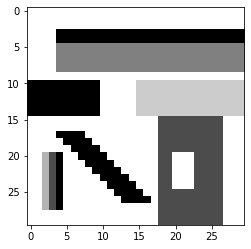

In [2]:
def create_random_binary_img_1():
    
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(float)

    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [3]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.5 -2.   0.5 -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.5  0.   0.5 -2.   0.   0.   0. ]
 [-2.   0.5  0.   6.5 -2.   0.  -2.   0.   0. ]
 [ 0.  -2.   0.5 -2.   9.  -2.   0.5 -2.   0. ]
 [ 0.   0.  -2.   0.  -2.   6.5  0.   0.5 -2. ]
 [ 0.   0.   0.  -2.   0.5  0.   4.5 -2.   0. ]
 [ 0.   0.   0.   0.  -2.   0.5 -2.   6.5 -2. ]
 [ 0.   0.   0.   0.   0.  -2.   0.  -2.   4. ]]


## Implementation

### Gradient Descent

In [4]:
def derivative_image_term(g, u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x+1, y+1] - g[x, y]
            elif x == 0 and y == u.shape[1]-1:
                result[x, y] = 0
            elif x == u.shape[0]-1 and y == 0:
                result[x, y] = 0
            elif x == u.shape[0]-1 and y == u.shape[1]-1:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x-1, y-1] - g[x-1, y-1]
            # Edges
            elif x == 0:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x+1, y+1] - g[x, y]
            elif x == u.shape[0]-1:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x-1, y-1] - g[x-1, y-1]
            elif  y == 0:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x+1, y+1] - g[x, y]
            elif y == u.shape[1]-1:
                result[x, y] = 0.5*u[x, y] + 0.5*u[x-1, y-1] - g[x-1, y-1]
            # Inside Image
            else:
                result[x, y] = u[x, y] + 0.5*u[x+1, y+1] + 0.5*u[x-1, y-1] - g[x, y] - g[x-1, y-1]
    return result

In [5]:
def derivative_GP_reg_term(u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 2*(2*u[x,y] - u[x+1, y] - u[x, y+1])
            elif x == 0 and y == u.shape[1]-1:
                result[x, y] = 2*(2*u[x,y] - u[x+1, y] - u[x, y-1])
            elif x == u.shape[0]-1 and y == 0:
                result[x, y] = 2*(2*u[x,y] - u[x-1, y] - u[x, y+1])
            elif x == u.shape[0]-1 and y == u.shape[1]-1:
                result[x, y] = 2*(2*u[x,y] - u[x-1, y] - u[x, y-1])
            # Edges
            elif x == 0:
                result[x, y] = 2*(3*u[x, y] - u[x+1, y] - u[x, y-1] - u[x, y+1])
            elif x == u.shape[0]-1:
                result[x, y] = 2*(3*u[x, y] - u[x-1, y] - u[x, y-1] - u[x, y+1])
            elif  y == 0:
                result[x, y] = 2*(3*u[x, y] - u[x+1, y] - u[x-1, y] - u[x, y+1])
            elif y == u.shape[1]-1:
                result[x, y] = 2*(3*u[x, y] - u[x+1, y] - u[x-1, y] - u[x, y-1])
            # Inside Image
            else:
                result[x, y] = 2*(4*u[x, y] -  u[x+1, y] - u[x-1, y] - u[x, y+1] - u[x, y-1])
    return result

In [6]:
def derivative_ATV_reg_term(u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = - np.sign(u[x+1, y] - u[x, y]) - np.sign(u[x, y+1] - u[x, y])
            elif x == 0 and y == u.shape[1]-1:
                result[x, y] = np.sign(u[x, y] - u[x, y-1]) - np.sign(u[x+1, y] - u[x, y])
            elif x == u.shape[0]-1 and y == 0:
                result[x, y] = np.sign(u[x, y] - u[x-1, y]) - np.sign(u[x, y+1] - u[x, y])
            elif x == u.shape[0]-1 and y == u.shape[1]-1:
                result[x, y] = np.sign(u[x, y] - u[x, y-1]) + np.sign(u[x, y] - u[x-1, y])
            # Edges
            elif x == 0:
                result[x, y] = - np.sign(u[x+1, y] - u[x, y]) - np.sign(u[x, y+1] - u[x, y]) - np.sign(u[x, y] - u[x, y-1])
            elif x == u.shape[0]-1:
                result[x, y] = np.sign(u[x, y] - u[x-1, y]) + np.sign(u[x, y] - u[x, y-1]) - np.sign(u[x, y+1] - u[x, y])
            elif  y == 0:
                result[x, y] = - np.sign(u[x+1, y] - u[x, y]) + np.sign(u[x, y] - u[x-1, y]) - np.sign(u[x, y+1] - u[x, y])
            elif y == u.shape[1]-1:
                result[x, y] = np.sign(u[x, y] - u[x, y-1]) + np.sign(u[x, y] - u[x-1, y]) - np.sign(u[x+1, y] - u[x, y])
            # Inside Image
            else:
                result[x, y] = np.sign(u[x, y] - u[x-1, y]) - np.sign(u[x+1, y] - u[x, y]) - np.sign(u[x, y+1] - u[x, y]) - np.sign(u[x, y] - u[x, y-1])
    return result

In [7]:
def GD(g, reg_lambda, mode="NoReg"):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    epsilon = 0.1
    margin = 0.000001
    
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]
    
    if (mode == "NoReg"):
        gradient = derivative_image_term(g, u)
        while (np.sum(np.power(gradient, 2)) > margin):
            u = u - epsilon * gradient
            gradient = derivative_image_term(g, u)
    elif (mode == "Gaussian"):
        gradient = derivative_image_term(g, u) + reg_lambda * derivative_GP_reg_term(u)
        # while (np.sum(np.power(gradient, 2)) > margin):
        for i in range(1000):
            u = u - epsilon * gradient
            gradient = derivative_image_term(g, u) + reg_lambda * derivative_GP_reg_term(u)
    elif (mode == "Anisotropic"):
        gradient = derivative_image_term(g, u) + reg_lambda * derivative_ATV_reg_term(u)
        for i in range(1000):
            u = u - epsilon * gradient
            gradient = derivative_image_term(g, u) + reg_lambda * derivative_ATV_reg_term(u)
        
    return u

### Linearization + Gauss-Seidel

In [8]:
def iterative_linearization(g, u, reg_lambda, kernel_index):
    m = u.shape[0]
    n = u.shape[1]
    
    vector_u = u.reshape(m*n, 1)
    
    H = hessian_matrix(u, reg_lambda, kernel_index)
    b = H * vector_u - (derivative_image_term(g, u) + reg_lambda * derivative_GP_reg_term(u)).reshape(m*n, 1)
    L = sp.tril(H, k=0)
    U = sp.triu(H, k=1)
    
    vector_u = inv(L) * (b - U * vector_u)
    
    u = vector_u.reshape(m,n)
    
    return u

In [9]:
import time
def LGS(g, reg_lambda, kernel_index):
    """
    Linearalized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    margin = 0.000001
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    old_u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]
    
    while(np.sum(np.power(old_u-u, 2)) > margin):
        old_u = u
        u = iterative_linearization(g, u, reg_lambda, kernel_index)
        
    return u

### Linearization + SOR

In [10]:
def iterative_linearization_SOR(g, u, reg_lambda, w, kernel_index):
    m = u.shape[0]
    n = u.shape[1]
    
    vector_u = u.reshape(m*n, 1)
    
    H = hessian_matrix(u, reg_lambda, kernel_index)
    L = sp.tril(H,k=-1)
    U = sp.triu(H,k=1)
    D = H - L - U
    b = H * vector_u - (derivative_image_term(g, u) + reg_lambda * derivative_GP_reg_term(u)).reshape(m*n, 1)
    
    vector_u = inv(D + w*L) * (w*b - (w*U + (w-1)*D) * vector_u)
    
    u = vector_u.reshape(m,n)
    
    return u

In [11]:
def LSOR(g, reg_lambda, w, kernel_index):
    """
    Linearized SOR Algorithm
    g: grayscale blyrry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    """
    margin = 0.000001
    
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    old_u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]
            
    while(np.sum(np.power(old_u-u, 2)) > margin):
        old_u = u
        u = iterative_linearization_SOR(g, u, reg_lambda, w, kernel_index)
    return u

### Parameters

In [12]:
reg_lambda = 0.0075 # lambda regularization parameter. you need to play with this 
# k matrix. Look below how to choose it 
k = 2


$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$



### Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [13]:
def image_blurring(image, kernel):
    blurred_image = np.zeros((image.shape[0] - 1, image.shape[1] - 1))
    for row in range(image.shape[0] - 1):
        for column in range(image.shape[1] - 1):
            blur_pixel = 0
            for p in range(kernel.shape[0]):
                for q in range(kernel.shape[1]):
                    blur_pixel += kernel[p, q] * image[row - p + 1, column - q + 1]
            blurred_image[row, column] = blur_pixel
    return blurred_image

In [14]:
img_org = sample_image = create_random_binary_img_1()

# TODO: define the kernel matrix here
kernel = np.array([[0.5,0],[0,0.5]])

# TODO: blur this image
img_blurred = image_blurring(sample_image, kernel)

### Image Checks

In [15]:
def compute_loss(g, u, k):
    loss = 0
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            convolution = 0
            for p in range(k.shape[0]):
                for q in range(k.shape[1]):
                    convolution += k[p, q] * u[x - p + 1, y - q +1]
            loss += (g[x,y] - convolution)**2
    return loss

## GRADIENT DESCENT

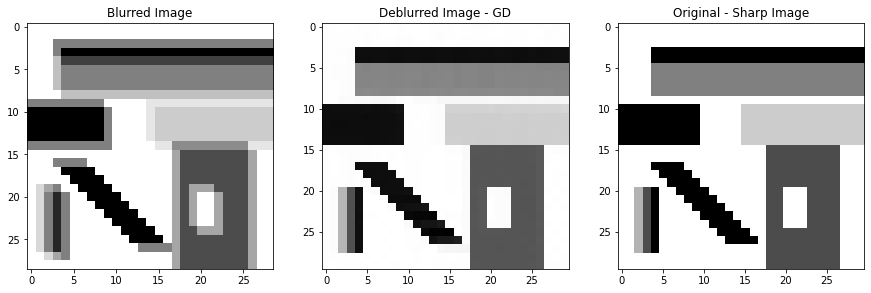

For lambda 0.00750	 
k_type 2
Loss Data Term = 0.02146
Sum of Squared Distance: deblurred vs. original = 0.09336


In [16]:
# run gradient descent algorithm
img_deblurred_gd = GD(img_blurred, reg_lambda, "Anisotropic")

# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)

# img_blurred = image_blurring(img_deblurred_gd, kernel)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")

# TODO: print the loss
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_gd, kernel):.5f}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {np.sum(np.power(img_deblurred_gd - sample_image, 2)):.5f}")  

## GAUSS - SEIDEL

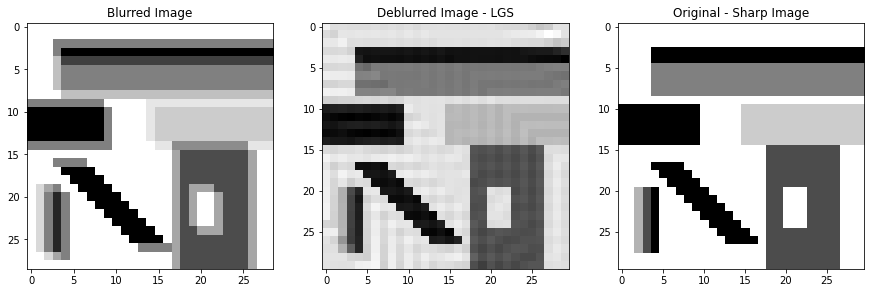

For lambda 0.00100
Loss Data Term = 0.00268
Sum of Squared Distance: deblurred vs. original = 1.34934


In [26]:
reg_lambda = 0.001

# run LGS algorithm
img_deblurred_gs = LGS(img_blurred, reg_lambda, k)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_gs, kernel):.5f}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {np.sum(np.power(img_deblurred_gs - sample_image, 2)):.5f}")  

## SOR

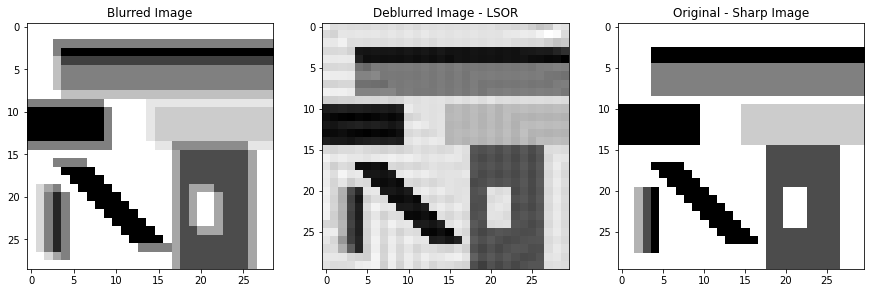

For lambda 0.00100
Loss Data Term = 0.00269
Sum of Squared Distance: deblurred vs. original = 1.42130


In [27]:
w = 0.5 #play with this

# run LSOR algorithm
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w, k)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org,cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_sor, kernel):.5f}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {np.sum(np.power(img_deblurred_sor - sample_image, 2)):.5f}")  